# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

/var/folders/bv/zvc9tyns1vs10pzppsb3b4nw0000gn/T/ipykernel_25544/866361824.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


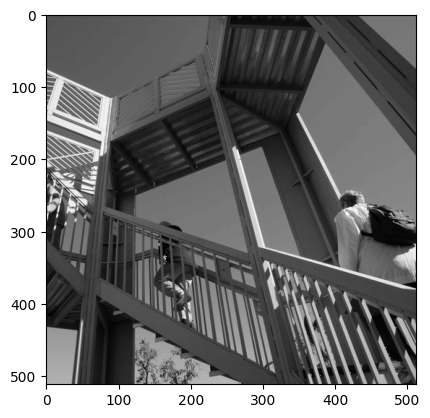

In [2]:
X = misc.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

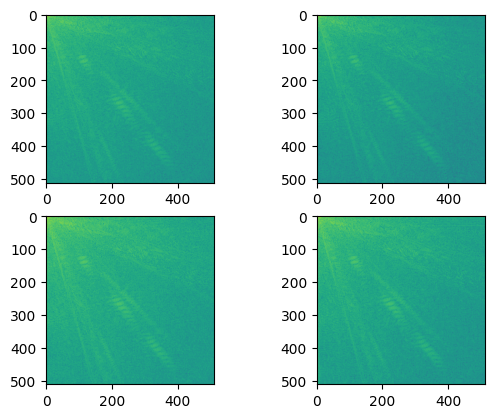

In [3]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

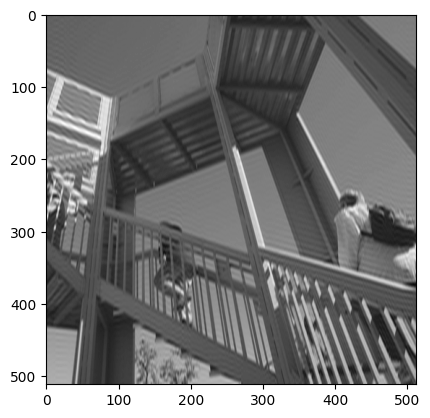

In [4]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

/var/folders/bv/zvc9tyns1vs10pzppsb3b4nw0000gn/T/ipykernel_25544/3175764158.py:2: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = misc.face()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


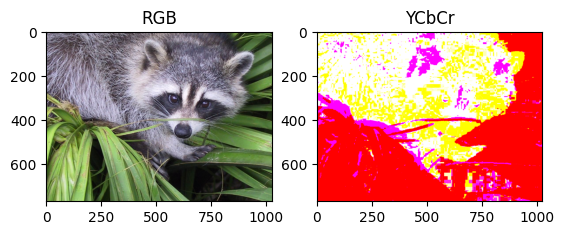

In [78]:
# RGB to Y'CbCr 
img = misc.face()
imgYcbcr = np.zeros_like(img, dtype = np.float32)


rgbToYcbcr = np.array([[0.299, 0.587, 0.114],
                        [-0.168736, -0.331264, 0.5],
                        [0.5, -0.418688, -0.081312]])

for i in range(len(img)):
    for j in range(len(img[0])):
        rgbPixel = img[i, j]
        ycbcrPixel = np.dot(rgbToYcbcr, rgbPixel)
        imgYcbcr[i, j] = ycbcrPixel


# Plot
plt.subplot(121).imshow(img)
plt.title('RGB')
plt.subplot(122).imshow(imgYcbcr)
plt.title('YCbCr')
plt.show()

X = imgYcbcr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


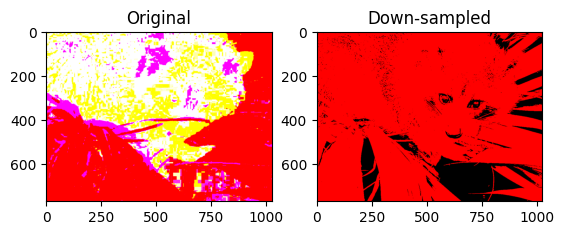

In [79]:
Q_down = 100

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down)

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


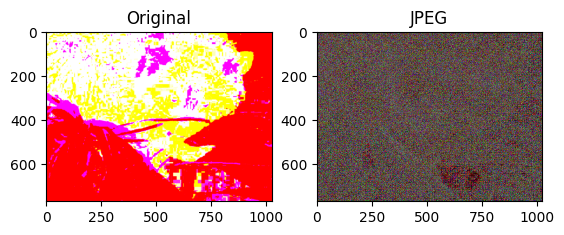

Prag MSE: 5420.544787118259
Componente în frecvență:[192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 189, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 186, 192, 189, 186, 192, 72, 177, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 189, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192

In [91]:
Q_jpeg_Y = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

Q_jpeg_CbCr = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                         [18, 21, 26, 66, 99, 99, 99, 99],
                         [24, 26, 56, 99, 99, 99, 99, 99],
                         [47, 66, 99, 99, 99, 99, 99, 99],
                         [99, 99, 99, 99, 99, 99, 99, 99],
                         [99, 99, 99, 99, 99, 99, 99, 99],
                         [99, 99, 99, 99, 99, 99, 99, 99],
                         [99, 99, 99, 99, 99, 99, 99, 99]])
pragMSE = 120


def calcMSE(oldImg, newImg):
    return np.mean((oldImg - newImg) ** 2)

def compJPEG(img):
    x_jpeg = np.zeros((len(img), len(img[0]), len(img[0, 0])))
    y_nnz = []
    y_jpeg_nnz = []

    for i in range(0, len(img), 8):
        for j in range(0, len(img[0]), 8):
            # Encoding
            x = img[i:i + 8, j:j + 8]
            y = dctn(x)
            Y = y[:, :, 0]
            Cb = y[:, :, 1]
            Cr = y[:, :, 2]
            y_jpeg_Y = Q_jpeg_Y * np.round(Y / Q_jpeg_Y)
            y_jpeg_Cb = Q_jpeg_Y * np.round(Cb / Q_jpeg_CbCr)
            y_jpeg_Cr = Q_jpeg_Y * np.round(Cr / Q_jpeg_CbCr)
            YCbCr = np.zeros((Y.shape[0], Y.shape[1], 3), dtype=np.uint8)
            YCbCr[:, :, 0] = y_jpeg_Y
            YCbCr[:, :, 1] = y_jpeg_Cb
            YCbCr[:, :, 2] = y_jpeg_Cr
            y_jpeg = np.array(YCbCr)
            
            # Decoding
            x_jpeg[i:i + 8, j:j + 8] = idctn(y_jpeg)

            # Results
            y_nnz.append(np.count_nonzero(y))
            y_jpeg_nnz.append(np.count_nonzero(y_jpeg))

    plt.subplot(121).imshow(img, cmap=plt.cm.gray)
    plt.title('Original')
    plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
    plt.title('JPEG')
    plt.show()
    print('Prag MSE: ' + str(calcMSE(X, x_jpeg)))
    print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))
    
    return x_jpeg

x_jpeg = compJPEG(X)
while  calcMSE(X, x_jpeg) < pragMSE: 
    Q_down += 10
    X_jpeg = X.copy()
    x_jpeg = Q_down*np.round(X_jpeg/Q_down)
    x_jpeg = compJPEG(x_jpeg)


# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.